In [45]:
import os
from patchify import unpatchify
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import glob
import matplotlib.pyplot as plt

In [46]:
patch_size=256
from custom_functions import predict_patches
from custom_metrics import f1,iou

### Model

In [47]:
# Define custom_objects dictionary with your metric functions
custom_objects = {'f1': f1, 'iou': iou}

# Load the model using the custom_objects parameter
root_model = load_model('root_model.h5', custom_objects=custom_objects)

In [48]:
image_path="Measurement_dataset\measurement_image_1.tif"
image, root_preds = predict_patches(image_path, root_model,patch_size=patch_size)

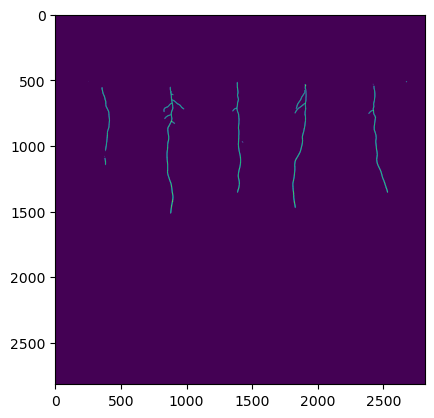

In [49]:
predicted_mask = unpatchify(root_preds, (image.shape[0], image.shape[1]))
# Predicted mask
plt.imshow(predicted_mask > 0.5)

### Instance segmentation 


In [50]:
def instance_segmentation(predictions, patch_size=patch_size, margin=30):
    _, thresholded_image = cv2.threshold(predictions, 0.5, 1, cv2.THRESH_BINARY)
    thresholded_image = thresholded_image.astype('uint8')

    # Extract connected components using connectedComponentsWithStats
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_image, 8, cv2.CV_32S)
    stats_indices = sorted(range(1, retval), key=lambda x: cv2.boundingRect((labels == x).astype(np.uint8))[0])


    instances = []
    nr_instances=0
    # Filtering elements based on criteria
    for label_index in stats_indices:
        stat = stats[label_index]
        x, y, w, h, a = stat
        if h > 400:
            if nr_instances < 5:
                # Cropping the region of interest (ROI) with a margin
                roi = thresholded_image[y-margin:y+h+margin, x-margin:x+w+margin]
                nr_instances+=1
                instances.append(roi)
                

    if nr_instances< 5:
        for label_index in stats_indices:
            stat = stats[label_index]
            x, y, w, h, a = stat
            if h > 150:
                if nr_instances< 5:
                    # Cropping the region of interest (ROI) with a margin
                    roi = thresholded_image[y-margin:y+h+margin, x-margin:x+w+margin]
                    nr_instances+=1
                    instances.append(roi)

    fig, axs = plt.subplots(1, 5, figsize=(10, 50))
    for i, instance in enumerate(instances):     
        axs[i].imshow(instance)
        axs[i].set_xticks([])  # Turn off x-axis labels
        axs[i].set_yticks([])  # Turn off y-axis labels
        axs[i].set_title("Instance: {}".format(i + 1))  # Add title with instance number
                        
    #print(len(instances))
    return nr_instances


5

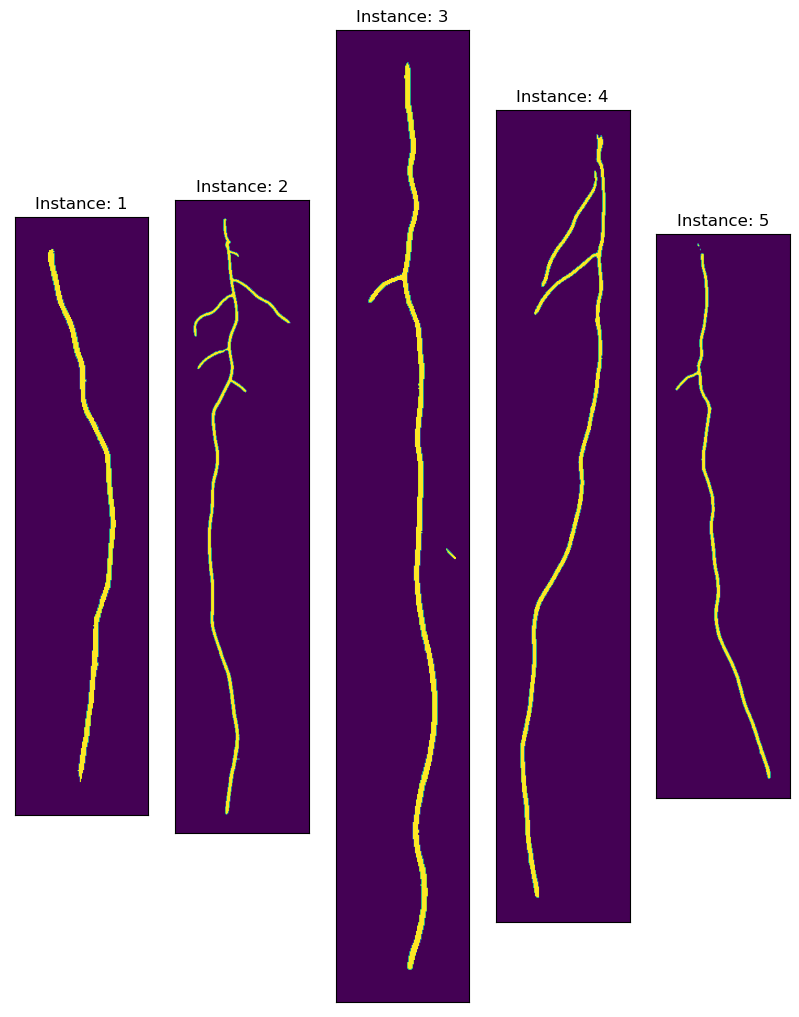

In [51]:
instance_segmentation(predicted_mask)